# Assignment 1

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [47]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# Download necessary resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /Users/mayi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mayi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/mayi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /Users/mayi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load dataset
file_path = os.path.expanduser("~/Desktop/School/6200/Project/Reviews.csv")  
df = pd.read_csv(file_path)

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [5]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [6]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817               

In [7]:
# Display the entire review text 
pd.set_option('display.max_colwidth', None)

In [8]:
# Add a new column for text length
df["Text_Length"] = df["Text"].astype(str).apply(len)

# Display descriptive statistics for text length
print(df["Text_Length"].describe())

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: Text_Length, dtype: float64


In [9]:
# Read a few random review samples
print(df["Text"].sample(10, random_state=45))

300665                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I have used this product before and found it to be the best product for jerk chicken. I could not find this product anywhere until my sister suggested I look on Amazon. There is nothing like it. It has a very unique taste.  I have tried other products out there and nothing compares to Busha Brownes Authentic Jerk Seasoning. I find myself wanting to go to jamaica and drink some rum and have jerk chicken.
167

In [10]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [11]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Handle missing values
    
    # 1. Remove HTML tags using a regex pattern
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags

    # 2. Replace URLs with a placeholder "URL"
    text = re.sub(r'http[s]?://\S+', 'URL', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Normalize whitespace (remove any leftover <br /> or extra spaces)
    text = re.sub(r"\s+", " ", text).strip()

    # 5. Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)

    # 6. Tokenize the text into words
    words = word_tokenize(text)

    # 7. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 8. Lemmatize the tokens
    cleaned_text = [lemmatizer.lemmatize(word) for word in words]

    # 9. Replace multiple spaces with a single space
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [12]:
# Select 100 random rows
random_sample = df.sample(100)

In [13]:
# Apply the updated cleaning function to the Text column
random_sample["Cleaned_Text"] = random_sample["Text"].apply(clean_text)

In [14]:
# Spot-checking
spotcheck_sample = random_sample[["Text", "Cleaned_Text"]].sample(5, random_state=45)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
170703                                                                                                                                                                                                                                             No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.   
172652                

## VADER

In [15]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Add words or phrases
custom_lexicon = {
    "meh": -0.5,
    "could be better": -0.3,
    "not great": -0.6,
    "disappointed": -0.8,
    "not happy": -0.7,
    "good product": 0.6,
    "love it": 0.8,
    "great taste": 0.7,
    "highly recommend": 0.9,
    "would buy again": 0.7,
    "favorite": 0.8,
    "best product": 0.9,
    "delicious": 0.8,
    "wonderful": 0.75,
    "impressed": 0.7,
    "good quality": 0.7,
    "pleasantly surprised": 0.6,
    "better than expected": 0.7,
    "amazing": 0.9,
    "perfect": 1.0,
    "satisfied": 0.6,
    "tasty": 0.7,
    "excited to try": 0.7,
    "nice texture": 0.6,
    "will buy again": 0.7
}

# Extend the lexicon
analyzer.lexicon.update(custom_lexicon)

In [20]:
# Tokenize the Cleaned_Text once and store it in a new column 'Tokens'
random_sample['Tokens'] = random_sample['Cleaned_Text'].apply(word_tokenize)

In [23]:
# Function to generate bigrams and trigrams
def generate_ngrams(text, n=2):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    n_grams = list(ngrams(tokens, n))  # Generate n-grams
    return ["_".join(gram) for gram in n_grams]  # Convert tuples to joined strings

# Tokenize the Cleaned_Text once and store it in a new column 'Tokens'
random_sample['Tokens'] = random_sample['Cleaned_Text'].apply(word_tokenize)

# Generate bigrams and trigrams
random_sample['Bigrams'] = random_sample['Cleaned_Text'].apply(lambda x: generate_ngrams(x, 2))
random_sample['Trigrams'] = random_sample['Cleaned_Text'].apply(lambda x: generate_ngrams(x, 3))

In [24]:
# Apply Feature Engineering on the pre-tokenized text
def extract_features_from_tokens(tokens, bigrams, trigrams):
    word_count = len(tokens)
    unique_word_count = len(set(tokens))
    avg_word_length = sum(len(word) for word in tokens) / word_count if word_count else 0

    # Combine tokens with bigrams and trigrams for sentiment analysis
    combined_text = " ".join(tokens + bigrams + trigrams)
    sentiment = analyzer.polarity_scores(combined_text)  # VADER expects a string

    return [word_count, unique_word_count, avg_word_length, sentiment['compound']]

# Apply the feature extraction on 'Tokens', 'Bigrams', and 'Trigrams'
random_sample[['Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']] = random_sample.apply(
    lambda row: pd.Series(extract_features_from_tokens(row['Tokens'], row['Bigrams'], row['Trigrams'])), axis=1
)

# Spot-check the results
print(random_sample[['Text', 'Cleaned_Text', 'Tokens', 'Bigrams', 'Trigrams', 'Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Text  \
170703                                                                                                                                                                                                                                                                                                                                              

In [25]:
def classify_sentiment(sentiment_score):
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Sentiment classification
random_sample['Sentiment_Label'] = random_sample['Sentiment_Score'].apply(classify_sentiment)

# Show some of the classified sentiments
print(random_sample[['Cleaned_Text', 'Sentiment_Score', 'Sentiment_Label']].head())

                                                                                                                                                                                                                                                                                                                                                                    Cleaned_Text  \
170703                                                                                                                                                                                                             obvious taste perfect decorating cakeshighly recommend check local michael joanns amazon usually competitive price local craft store wayy overprice amazoncom   
172652                                                                                                                                                                                                                                                          

In [26]:
# Extract sentiment predictions from VADER
random_sample['VADER_Sentiment'] = random_sample['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0.05 else 'Negative' if score < -0.05 else 'Neutral'
)

In [27]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text', 'VADER_Sentiment']].sample(5, random_state=45)

print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
170703                                                                                                                                                                                                                                             No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.   
172652                

In [28]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print("-" * 50)

Review Text: No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.
VADER Sentiment: Positive
--------------------------------------------------
Review Text: These are my second favorite pralines from the French Quarter, and I thoroughly enjoyed eating them. They were shipped promptly and arrived a few days later, to the joy of my palate.
VADER Sentiment: Positive
--------------------------------------------------
Review Text: I have tried these bars in the past but was very disappointed with this product, I ordered, went to eat the bars and they were covered with a white film and crumbled.  Amazon was great and understood my problem and sent another order.  This order was also covered with a white film and crumbled.  I wasnt going to do a 3rd time.  Kind of turned me off on ordering this kind again, 

## TextBlob

In [29]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity, 'Positive' if blob.sentiment.polarity > 0.05 else ('Negative' if blob.sentiment.polarity < -0.05 else 'Neutral')

# Apply the function and append new columns
random_sample[['TextBlob_Polarity', 'TextBlob_Subjectivity', 'TextBlob_Sentiment']] = random_sample['Cleaned_Text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display the updated DataFrame
random_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Trigrams,Word_Count,Unique_Word_Count,Avg_Word_Length,Sentiment_Score,Sentiment_Label,VADER_Sentiment,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Sentiment
170703,170704,B000PWKNUK,A13BBPU9UBQXDR,Shannon L. Toohey,10,11,4,1280793600,So versatile! Must have for cake decorators,No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.,...,"[obvious_taste_perfect, taste_perfect_decorating, perfect_decorating_cakeshighly, decorating_cakeshighly_recommend, cakeshighly_recommend_check, recommend_check_local, check_local_michael, local_michael_joanns, michael_joanns_amazon, joanns_amazon_usually, amazon_usually_competitive, usually_competitive_price, competitive_price_local, price_local_craft, local_craft_store, craft_store_wayy, store_wayy_overprice, wayy_overprice_amazoncom]",20.0,19.0,6.900000,0.7096,Positive,Positive,0.150000,0.350000,Positive
172652,172653,B0026L2MFC,A1Z8D5QK9MU1GW,Brian J,0,0,5,1335484800,Delicious!,"These are my second favorite pralines from the French Quarter, and I thoroughly enjoyed eating them. They were shipped promptly and arrived a few days later, to the joy of my palate.",...,"[second_favorite_praline, favorite_praline_french, praline_french_quarter, french_quarter_thoroughly, quarter_thoroughly_enjoyed, thoroughly_enjoyed_eating, enjoyed_eating_shipped, eating_shipped_promptly, shipped_promptly_arrived, promptly_arrived_day, arrived_day_later, day_later_joy, later_joy_palate]",15.0,15.0,6.400000,0.8479,Positive,Positive,0.300000,0.316667,Positive
269709,269710,B0001GDC4O,A33SG2UA24DJ9P,tomjonesrocks,2,2,5,1221177600,"Tried a variety of pods, and these have been the best","We tried a variety of pods in our Francis Francis X5 and these were by far the best. Been ordering this stuff for years now. The taste is very smooth and not bitter. This stuff spoils us because the espresso at the coffeeshops around here are never as good.<br /><br />Of course, crema-wise you'll still do better with whole beans and a high quality grinder. We get a thin crema top with these but that's about it. As I think everyone understands there's a tradeoff to be made with pods--and no other pod I've tried has ever been any better for me in this respect--I haven't held that against this product.<br /><br />Highly recommended.",...,"[tried_variety_pod, variety_pod_francis, pod_francis_francis, francis_francis_x, francis_x_far, x_far_best, far_best_ordering, best_ordering_stuff, ordering_stuff_year, stuff_year_taste, year_taste_smooth, taste_smooth_bitter, smooth_bitter_stuff, bitter_stuff_spoil, stuff_spoil_u, spoil_u_espresso, u_espresso_coffeeshops, espresso_coffeeshops_around, coffeeshops_around_never, around_never_goodof, never_goodof_course, goodof_course_cremawise, course_cremawise_youll, cremawise_youll_still, youll_still_better, still_better_whole, better_whole_bean, whole_bean_high, bean_high_quality, high_quality_grinder, quality_grinder_get, grinder_get_thin, get_thin_crema, thin_crema_top, crema_top_thats, top_thats_think, thats_think_everyone, think_everyone_understands, everyone_understands_there, understands_there_tradeoff, there_tradeoff_made, tradeoff_made_podsand, made_podsand_pod, podsand_pod_ive, pod_ive_tried, ive_tried_ever, tried_ever_better, ever_better_respecti, better_respecti_havent, respecti_havent_held, havent_held_producthighly, held_producthighly_recommended]",54.0,49.0,5.685185,0.8130,Positive,Positive,0.286000,0.559000,Positive
59428,59429,B000E3XCEO,A2GUZLOFTSINWE,Eric from Maine,0,0,5,1304294400,Our Favorite Zatarain's Meal,"Outstanding meal. Infact it's our favorite Zatarain's meal, and has oddly become hard to find. We didn't find this to be too salty, but neither are we on a low sodium diet. It's easy to

In [30]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text','VADER_Sentiment', 'TextBlob_Sentiment']].sample(5)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Text  \
379306                                               

In [31]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: This stuff is the only grain-free canned cat food that all four of my furry buddies agree on!
VADER Sentiment: Positive
TextBlob_Sentiment: Neutral
--------------------------------------------------
Review Text: I purchased and received a case of these 6 oz items mid-March-2008. I used two cans then and in reflection remember one of them spewing some paste when first pierced by the opener. Tonight I've gone to open another can and this time it really projected out the paste when pierced with the opener. So I decide to check over the others and find 4 of them really BULGING - each end pouched outwards a centimeter or so. And another 8 cans showing 1 to 3 mm bulges at each end!  This case has been in an A/C-ed home in a dark closet.<br /><br />The case of small cans appears to come from 3 different lot numbers (OPJCS 6 ASHX24 1121, OPJCS 6 ASHX24 1122 AND OPJCS 6 ASHX24 1123) Note the 1121/1122/1123 code differs.<br /><br />With just my visual inspection it appears all affec

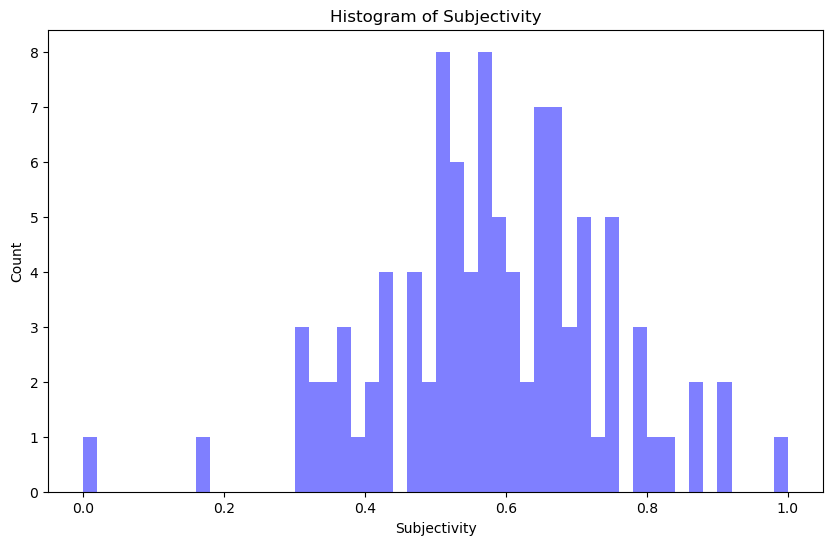

In [32]:
#Draw a histogram that shows the distribution of subjectivity: Count vs. subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show()

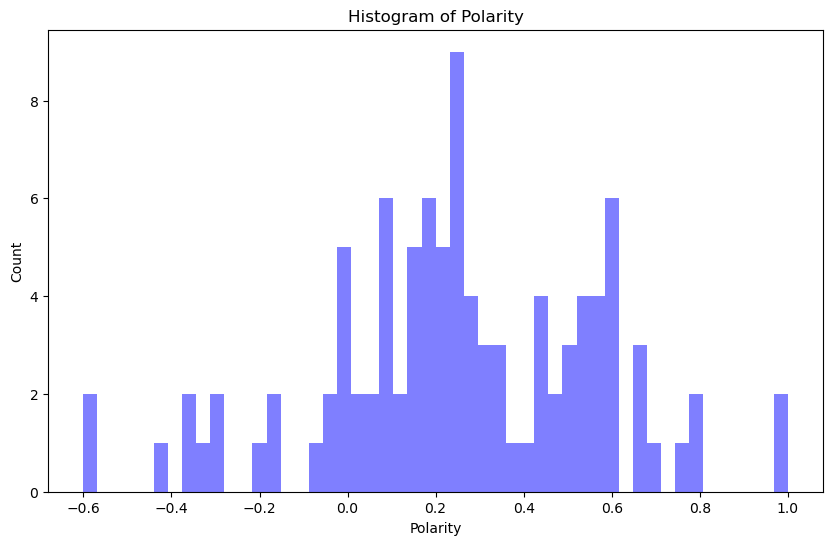

In [33]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

## Analyze and Review

In [34]:
analyzer = SentimentIntensityAnalyzer()
# Initialize VADER sentiment analyzer

In [35]:
for idx, row in random_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: These are my second favorite pralines from the French Quarter, and I thoroughly enjoyed eating them. They were shipped promptly and arrived a few days later, to the joy of my palate.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: We tried a variety of pods in our Francis Francis X5 and these were by far the best.  Been ordering this stuff for years now.  The taste is very smooth and not bitter.  This stuff spoils us because the espresso at the coffeeshops around here are never as good.<br /><br />Of course, crema-wise you'll still do better with w

In [36]:
# Find cases where models disagree
disagreed_df = random_sample[random_sample["VADER_Sentiment"] != random_sample["TextBlob_Sentiment"]]
print("\n Examples where models disagree (need manual review):")
print("-" * 50)
for idx, row in disagreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)


 Examples where models disagree (need manual review):
--------------------------------------------------
Review Text: Our lil shih tzu puppy cannot get enough of it. Everytime she sees the bag, she starts jumping up and down!!! Our older shih tzu doesnt like it at all but its perfect for puppies! Will definitely reorder!
VADER Sentiment: Neutral
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: My daughter and I both received the Keurig coffee machine as a Christmas gift.  I just<br />happened to see this product and decided to give it a try.  After one cup I was<br />sold on it. I absolutely love it, and I hate drinks with aspartame...won't touch them.<br />No aftertaste problem as far as I'm concerned.  I drink the 8 oz. size.  Oh, and I<br />gave daughter small stocking of "samples".  This was the first thing she grabbed and<br />she likes it too.
VADER Sentiment: Positive
TextBlob_Sentiment: Neutral
---------------------------------------

In [37]:
# Find cases where models agree
agreed_df = random_sample[random_sample["VADER_Sentiment"] == random_sample["TextBlob_Sentiment"]]
print("Examples where models agree (likely correct):")
print("-" * 50)
for idx, row in agreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Examples where models agree (likely correct):
--------------------------------------------------
Review Text: No obvious taste! So perfect for decorating cakes!!<br /><br />Highly recommend you check your local Michaels or Joann's. Amazon usually has competitive prices but these are $3-4 at your local craft store - $8 is WAYY overprice on amazon.com.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: These are my second favorite pralines from the French Quarter, and I thoroughly enjoyed eating them. They were shipped promptly and arrived a few days later, to the joy of my palate.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: We tried a variety of pods in our Francis Francis X5 and these were by far the best.  Been ordering this stuff for years now.  The taste is very smooth and not bitter.  This stuff spoils us because the espresso at the coffeesh

In [38]:
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))["compound"]
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"
# Function to get sentiment labels from VADER

In [39]:
# Function to get sentiment labels from TextBlob
def get_textblob_sentiment(text):
    score = TextBlob(str(text)).sentiment.polarity
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

In [40]:
#which model would you use and why?
import time

# Measure VADER speed
start_time = time.time()
random_sample["VADER_Sentiment"] = random_sample["Text"].apply(get_vader_sentiment)
vader_time = time.time() - start_time

# Measure TextBlob speed
start_time = time.time()
random_sample["TextBlob Sentiment"] = random_sample["Text"].apply(get_textblob_sentiment)
textblob_time = time.time() - start_time

# Compare models
comparison = {
    "Criteria": ["Speed", "Accuracy", "Interpretability", "Handling Sarcasm", "Ease of Use"],
    "VADER": [vader_time, "Good for strong emotions", "Easy to understand", "Struggles with sarcasm", "Very easy"],
    "TextBlob": [textblob_time, "Basic polarity analysis", "Simple", "Struggles with context", "Very easy"]
}

comparison_df = pd.DataFrame(comparison)
print("\n Model Comparison:")
print(comparison_df)


 Model Comparison:
           Criteria                     VADER                 TextBlob
0             Speed                   0.03611                  0.01916
1          Accuracy  Good for strong emotions  Basic polarity analysis
2  Interpretability        Easy to understand                   Simple
3  Handling Sarcasm    Struggles with sarcasm   Struggles with context
4       Ease of Use                 Very easy                Very easy


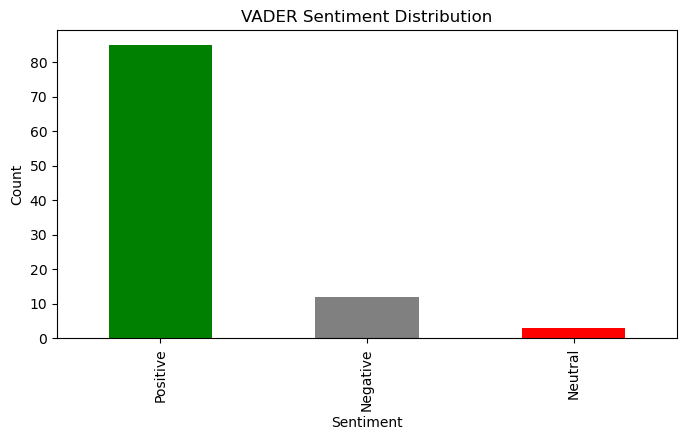

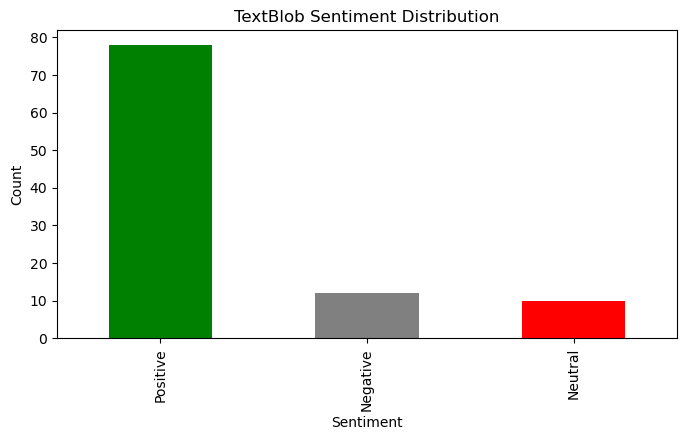

In [41]:
#visualize Sentiment Distribution
import matplotlib.pyplot as plt

# Count sentiment labels
vader_counts = random_sample["VADER_Sentiment"].value_counts()
textblob_counts = random_sample["TextBlob_Sentiment"].value_counts()

# Plot VADER Sentiment Distribution
plt.figure(figsize=(8, 4))
vader_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Plot TextBlob Sentiment Distribution
plt.figure(figsize=(8, 4))
textblob_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [44]:
# Find cases where VADER and TextBlob disagree
disagreement_cases = random_sample[random_sample['VADER_Sentiment'] != random_sample['TextBlob_Sentiment']]

# Display the first few disagreements
print(disagreement_cases[['Cleaned_Text', 'VADER_Sentiment', 'TextBlob_Sentiment']])

In [46]:
# Use TextBlob's classification as a "baseline" and compare VADER against it
agreement_rate = accuracy_score(random_sample['VADER_Sentiment'], random_sample['TextBlob_Sentiment'])

print(f"Agreement Rate between VADER and TextBlob: {agreement_rate:.2f}")

Agreement Rate between VADER and TextBlob: 0.84


In [41]:
#Questions: Do you agree with the models?
# we agree with the models(VADER and TextBlob), here are some key points: VADER is great for short, social media-like text and captures emotion-driven words well
#TextBlob has more rules and relies on world polarity, which might miss context and sarcasm

#if VADER and TextBlob both classify a review as "positive" or "negative", it is likely correct.
#if disagree, it suggests the text is more complex
#A neutral classfication might indicate mixed sentiments